In [1]:
import tensorflow as tf
print(tf.__version__)
import tf_keras as keras
# from tensorflow import keras
# import tf_keras as keras
# import keras as keras

# from tf.keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.utils import to_categorical
from keras.layers import Conv1D, Dense, Flatten, Input, LSTM, Dropout, BatchNormalization, TimeDistributed, Bidirectional
# from tensorflow.keras.utils.np_utils import to_categorical

import pandas as pd
import numpy as np
from pathlib import Path
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

2.19.0



In [2]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import random


# Parameters
WINDOW_SIZE = 300
STEP_SIZE = 275
TOLERANCE = 0.1
MAX = 20000
DATA_DIR = str(Path.cwd().parent.parent / 'Reffit' / 'Processed')
LABELS = []
X = []
y = []
well_represented = ['Fridge','Freezer','Washing Machine','Washer Dryer','Tumble Dryer','Dishwasher','Microwave','Toaster','Kettle',
                'Computer','Television','Electric Heater','Hi-Fi','Overhead Fan']

def extract_windows(signal):
    signal = signal / np.max(np.abs(signal)) if np.max(np.abs(signal)) > 0 else signal
    windows = []
    for start in range(0, len(signal) - WINDOW_SIZE, STEP_SIZE):
        window = signal[start:start + WINDOW_SIZE]
        windows.append(window)
    return windows

def process_file(file_path, label_idx):
    print(f"Processing file: {file_path}")
    df = pd.read_csv(file_path)
    with open(file_path) as f:
        appliance_name = f.readline().strip().split(",")[1]

    if appliance_name not in df.columns:
        return []

    signal = df[appliance_name].fillna(0).values.astype(np.float32)
    return [(window, label_idx) for window in extract_windows(signal)]

def load_balanced_dataset(data_dir, well_represented=well_represented):
    global LABELS, X, y

    label_map = {name: i for i, name in enumerate(well_represented)}
    all_windows = {label: [] for label in well_represented}

    # Step 1: Load all data first
    for class_dir in sorted(Path(data_dir).iterdir()):
        if not class_dir.is_dir():
            continue
        class_name = class_dir.name
        if class_name not in well_represented:
            continue
        label_idx = label_map[class_name]
        if class_name not in LABELS:
            LABELS.append(class_name)
        for file in class_dir.glob("*.csv"):
            windows = process_file(file, label_idx)
            all_windows[class_name].extend(windows)

    # Step 2: Select reference class and determine target range
    ref_class = random.choice(well_represented)
    original_ref_count = len(all_windows[ref_class])
    ref_count = min(MAX, original_ref_count)
    print(f"Reference class: {ref_class} (using {ref_count} windows, originally had {original_ref_count})")

    min_required = int(ref_count * (1 - TOLERANCE))
    max_allowed = int(ref_count * (1 + TOLERANCE))
    cap = min(MAX, max_allowed)


    # Step 3: Apply sampling per class
    for label in well_represented:
        class_windows = all_windows[label]
        # needed = random.randint(min_required, cap)
        needed = MAX

        if len(class_windows) >= needed:
            chosen = random.sample(class_windows, needed)
        else:
            repeat_count = (needed // len(class_windows)) + 1
            extended = class_windows * repeat_count
            chosen = extended[:needed]
            chosen = [(w + np.random.normal(0, 0.01, size=w.shape).astype(np.float32), lbl)
                      for (w, lbl) in chosen]

        for window, label_idx in chosen:
            X.append(window)
            y.append(label_idx)

        print(f"{label}: {len(chosen)} samples")

    print("\nClass balance (target ±{:.1f}%, max cap = {}):".format(TOLERANCE * 100, MAX))
    for label in well_represented:
        print(f"{label}: {sum(np.array(y) == label_map[label])} windows")

    X_np = np.array(X)[..., np.newaxis]
    y_np = to_categorical(y, num_classes=len(LABELS))
    return X_np, y_np


X, y = load_balanced_dataset(DATA_DIR)

Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\Processed\Computer\Computer_House_1.csv_0.csv
Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\Processed\Computer\Computer_House_1.csv_1.csv
Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\Processed\Computer\Computer_House_1.csv_112.csv
Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\Processed\Computer\Computer_House_1.csv_115.csv
Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\Processed\Computer\Computer_House_1.csv_116.csv
Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\Processed\Computer\Computer_House_1.csv_117.csv
Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\Pr

In [ ]:

# Train-test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42)

def print_class_distribution(y_set, set_name):
    class_counts = np.sum(y_set, axis=0)
    print(f"\nClass distribution in {set_name} set:")
    for idx, count in enumerate(class_counts):
        print(f"{LABELS[idx]:<20}: {int(count)} samples")

# Print stats
print_class_distribution(y_train, "TRAIN")
print_class_distribution(y_val, "VALIDATION")
print_class_distribution(y_test, "TEST")




Class distribution in TRAIN set:
Computer            : 12098 samples
Dishwasher          : 11968 samples
Electric Heater     : 12068 samples
Freezer             : 12016 samples
Fridge              : 12104 samples
Hi-Fi               : 11980 samples
Kettle              : 12018 samples
Microwave           : 11969 samples
Overhead Fan        : 11915 samples
Television          : 12022 samples
Toaster             : 11962 samples
Tumble Dryer        : 12048 samples
Washer Dryer        : 11884 samples
Washing Machine     : 11948 samples

Class distribution in VALIDATION set:
Computer            : 5540 samples
Dishwasher          : 5554 samples
Electric Heater     : 5576 samples
Freezer             : 5623 samples
Fridge              : 5541 samples
Hi-Fi               : 5549 samples
Kettle              : 5625 samples
Microwave           : 5615 samples
Overhead Fan        : 5689 samples
Television          : 5654 samples
Toaster             : 5671 samples
Tumble Dryer        : 5535 samples
Was

In [4]:
from Conv1D_GLU import Conv1DGLU
from ResidualBlock import ResidualBlock
from keras.models import Model
from keras.layers import Add

def build_glu_cnn_lstm_model(window_size, num_classes):
    input_layer = Input(shape=(window_size, 1))
    print(f"Input shape: {input_layer.shape}")

    # x = Conv1DGLU(filters=64, kernel_size=5)(input_layer)
    x = ResidualBlock(Conv1DGLU(filters=64, kernel_size=5), filters=64)(input_layer)
    x = MaxPooling1D(pool_size=2, strides=2)(x)

    print(f"Input shape: {x.shape}")
    # input_layer = x  # Save the input for residual connection
    # x2 = Conv1DGLU(filters=128, kernel_size=3)(x)
    x = ResidualBlock(Conv1DGLU(filters=128, kernel_size=3), filters=128)(x)
    x = MaxPooling1D(pool_size=2, strides=2)(x)

    x = Dropout(0.2)(x)

    # Optional LSTM
    x = LSTM(64)(x)

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)

    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [5]:
from tensorflow.keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(
    monitor='val_loss',       # or 'val_accuracy'
    patience=5,               # number of epochs with no improvement before stopping
    restore_best_weights=True
)

In [7]:
model = build_glu_cnn_lstm_model(WINDOW_SIZE, num_classes=len(LABELS))
model.summary()

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    verbose=1
)


Input shape: (None, 300, 1)
Input shape: (None, 150, 64)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 300, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_2                │ (None, 300, 64)        │           896 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 150, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_3                │ (None, 150, 128)       │        57,728 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 75, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 75, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 14)             │         1,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,158 (461.55 KB)

 Trainable params: 118,158 (461.55 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 186s 69ms/step - accuracy: 0.3622 - loss: 1.7150 - val_accuracy: 0.6196 - val_loss: 0.9400
Epoch 2/10
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 189s 72ms/step - accuracy: 0.6418 - loss: 0.9237 - val_accuracy: 0.7097 - val_loss: 0.7406
Epoch 3/10
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 189s 72ms/step - accuracy: 0.6964 - loss: 0.7768 - val_accuracy: 0.7261 - val_loss: 0.6782
Epoch 4/10
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 191s 73ms/step - accuracy: 0.7197 - loss: 0.7215 - val_accuracy: 0.7340 - val_loss: 0.6530
Epoch 5/10
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 208s 79ms/step - accuracy: 0.7532 - loss: 0.6538 - val_accuracy: 0.7359 - val_loss: 0.6457
Epoch 6/10
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 235s 89ms/step - accuracy: 0.7713 - loss: 0.6173 - val_accuracy: 0.7611 - val_loss: 0.6371
Epoch 7/10
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 267s 102ms/step - accuracy: 0.7764 - loss: 0.5946 - val_accuracy: 0.7709 - val_loss: 0.5959
Epoch 8/10
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 255s 97ms/step - accuracy:

In [10]:
predictions = model.predict(X_test)
probs = np.argmax(predictions,axis = 1)
print(probs)

1050/1050 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step
[ 4 12  9 ... 10  6  2]


In [13]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues,
                          figsize=(12, 10),
                          fontsize=10):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=fontsize+2)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=60, fontsize=fontsize)
    plt.yticks(tick_marks, classes, fontsize=fontsize)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm[i, j]:.2f}' if normalize else f'{cm[i, j]}',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=fontsize)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=fontsize)
    plt.xlabel('Predicted label', fontsize=fontsize)
    plt.show()


Confusion matrix, without normalization
[[1513  269    2    0    0    0  318    0    0  140  103    0   17    0]
 [ 126 1979    1    4    2    1  222    0    0   64   77    1    1    0]
 [   0    0 2275    8    0   51    0    0    0    0    2   15    1    4]
 [   0    0   26 2290    0    5    0   12    0    0    0   28    0    0]
 [   0    0   39   31 2246    0    0    0    4    0    0   28    0    7]
 [   0    0 1057    4    0 1342    0    0    0    0    0   68    0    0]
 [   0    1    0    0    2    0 2072    0    1   89   78    2  112    0]
 [   0    0    0    0    0    0    0 2416    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0 2163    0    1    0    0  232]
 [   7    4    1   13    0    0   74    0   17 1746  311    3  143    5]
 [  13    7    0    1    0    0   88    0   29  957  955    0  314    3]
 [   0    0  576    0    0   35    0    0   16    0    0 1710    0   80]
 [   5    1    0   11    0    0    0    0   23  130   26    3 2309    8]
 [   0    0

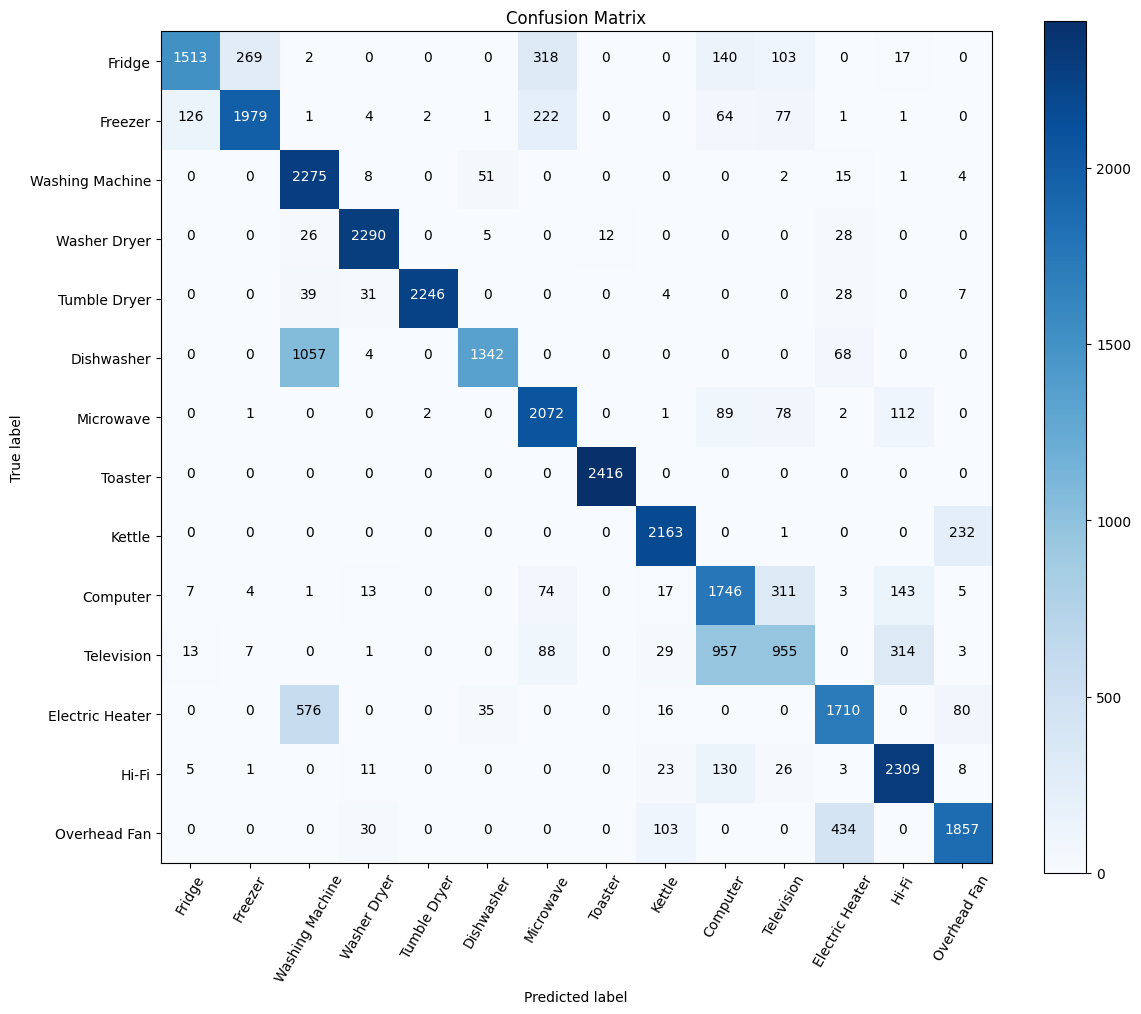

In [14]:
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, probs)
plot_confusion_matrix(cm,classes = well_represented)